Working On HealthAnalytic Dataset

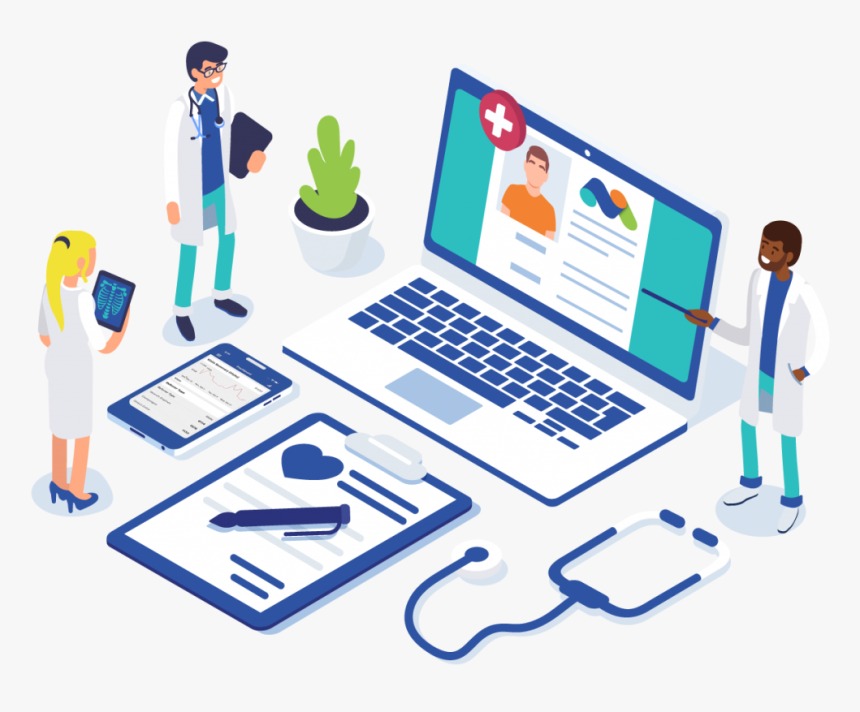

In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



**Variable Features of the datasets to be represented below**

In [ ]:
pd.read_excel('/kaggle/input/healthcare-analytics/Train/Data_Dictionary.xlsx')

Patient Profile

In [ ]:
patient_profiles=pd.read_csv('/kaggle/input/healthcare-analytics/Train/Patient_Profile.csv')
patient_profiles=patient_profiles.dropna()
patient_profiles.head()
patient_profiles.info()

In [ ]:
patient_profiles.head()

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(patient_profiles.sort_values('Age').Age)

**People of Age group of 39-45 were the more ones to the health camps**

In [ ]:
sns.countplot(patient_profiles.sort_values('City_Type').City_Type)

Details about First Camp Held

In [ ]:
first_camp=pd.read_csv('/kaggle/input/healthcare-analytics/Train/First_Health_Camp_Attended.csv')
first_camp=first_camp.iloc[:,:4]
first_camp=first_camp.dropna()
first_camp.head()

In [ ]:
first_camp.info()

In [ ]:
first_camp.corr()

**This Shows a good relation of Donation And Health Score**

In [ ]:
plt.scatter(first_camp['Donation'],first_camp['Health_Score'],color='red')
plt.xlabel('Donation',fontsize=10)
plt.ylabel('Health_Score',fontsize=10)

Details about the Second camp Held

In [ ]:
second_camp=pd.read_csv('/kaggle/input/healthcare-analytics/Train/Second_Health_Camp_Attended.csv')
second_camp=second_camp.dropna()
second_camp.head()

In [ ]:
sns.distplot(second_camp['Health Score'])

Third Camp

In [ ]:
third_camp=pd.read_csv('/kaggle/input/healthcare-analytics/Train/Third_Health_Camp_Attended.csv')
third_camp=third_camp.dropna()
third_camp.head()

Training Set

In [ ]:
train=pd.read_csv('/kaggle/input/healthcare-analytics/Train/Train.csv')
train=train.dropna()
train.head()

Merging Patient proflies and first Camp DataFrames

In [ ]:
merged=pd.merge(patient_profiles,first_camp,how='inner',on='Patient_ID').set_index('Health_Camp_ID')
merged['City_Type']=merged['City_Type'].replace({'D':4,'A':1,'B':2,'C':3,'E':5,'F':6,'G':7,'H':8,'I':9})
merged['Employer_Category']=merged['Employer_Category'].replace({'BFSI':0,'Technology':1, 'Education':2, 'Consulting':3, 'Manufacturing':4,
       'Software Industry':5, 'Others':6, 'Health':7, 'Retail':8, 'Transport':9,
       'Broadcasting':10, 'Food':11, 'Telecom':12, 'Real Estate':13})
merged=merged.drop(merged.iloc[:,1:5],axis=1) 
merged=merged[(merged['Income']!='None')&(merged['Age']!='None')&(merged['Education_Score']!='None')]
merged['Income']=merged['Income'].astype('float')
merged['Age']=merged['Age'].astype('float')
merged['Education_Score']=merged['Education_Score'].astype('float')
merged.head()


Creating Age Groups

In [ ]:
def Agegroup(x):
    if x<=35:
        return 'Young Group'
    if x<=50:
        return 'Adult Group'
    if x>50:
        return 'Old Group'
merged['Age_Group']=merged['Age'].apply(Agegroup)
merged.head()

In [ ]:
merged.info()

In [ ]:
merged.corr()

More Dominant features towrads good health Score are Donation,Age

In [ ]:
sns.barplot(x='Age_Group',y='Health_Score',data=merged,estimator=np.median)
plt.title('Comparision of Health Score and the Age_Group')

Merging Training Set with Above merged dataframes

In [ ]:
Train=pd.merge(train,merged,how='inner',on='Patient_ID')
Train=Train.drop(['Registration_Date','First_Interaction','Health_Camp_ID'],axis=1)
Train=Train.drop_duplicates()
grouped=Train.groupby(['Patient_ID'])['Var1','Var2','Var3','Var4','Var5','Income','Education_Score','Age','City_Type','Employer_Category','Donation','Health_Score'].mean()
grouped.head()

Creating column called prediction with Health Score >0.55 as 1 and less than it to 0

In [ ]:
grouped['Prediction']=np.where(grouped['Health_Score']>0.55,1,0)
grouped.head()

In [ ]:
grouped['Range_for_Health_Score']=pd.cut(grouped.Health_Score,bins=10)
grouped.head()

Show count of people in different Health_Score Range

In [ ]:
sns.countplot(grouped.sort_values('Range_for_Health_Score').Range_for_Health_Score)
plt.xticks(rotation=90)

Shows range of (0.41-0.5) for Health_Score is the most one

Merging again with the third camp dataframe

In [ ]:
Group=grouped.reset_index()
Merge=pd.merge(grouped,third_camp,how='inner',on='Patient_ID')
Merge=Merge.drop(['Health_Camp_ID'],axis=1)
Merge=Merge.drop_duplicates()
Merge.head()

In [ ]:
Merge.corr()

**Shows all the Vars are  highly correlated to each other

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(Merge.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(20,220,n=200))

In [ ]:
sns.pairplot(data=Merge,x_vars=['Health_Score'],y_vars=['Var1','Var2','Var5','City_Type','Age','Donation','Income'],hue='Range_for_Health_Score')

In [ ]:
sns.barplot(x='Number_of_stall_visited',y='Last_Stall_Visited_Number',data=Merge,estimator=np.median)

Model Preparation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
x=Merge[['Var1','Var2','Var5','City_Type','Age','Donation','Income','Number_of_stall_visited','Last_Stall_Visited_Number']]
y=Merge[['Prediction']]
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [ ]:
lr=LogisticRegression(solver='newton-cg',C=10,fit_intercept=True,intercept_scaling=10,dual=False,penalty='l2').fit(x_train,y_train)
pred=lr.predict(x_test)

In [ ]:
classification=metrics.classification_report(
    digits=4,
    y_true=y_test,
    y_pred=pred)
print(classification)

In [ ]:
y_score_lr = lr.fit(x_train, y_train).decision_function(x_test)
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, y_score_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
plt.figure(figsize=(10,10))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='Area under ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='dashdot')
plt.axes().set_aspect('equal')
plt.show()

Checking on Test Set

In [ ]:
test=pd.read_csv('/kaggle/input/healthcare-analytics/Train/test.csv')
test=test.dropna()
test.head()

In [ ]:
Test=pd.merge(test,merged,how='inner',on='Patient_ID')
Test=Test.drop(['Registration_Date','First_Interaction','Health_Camp_ID'],axis=1)
Test=Test.drop_duplicates()
group_test=Test.groupby(['Patient_ID'])['Var1','Var2','Var5','Income','Age','City_Type','Donation'].mean()
group_test=group_test.reset_index()
grouped_test=pd.merge(group_test,third_camp,how='inner',on='Patient_ID')
grouped_test=grouped_test.drop(['Health_Camp_ID'],axis=1)
grouped_test=grouped_test.drop_duplicates()
grouped_test.head()

In [ ]:
X=grouped_test[['Var1','Var2','Var5','Income','Age','City_Type','Donation','Number_of_stall_visited','Last_Stall_Visited_Number']]
test_predict=lr.predict(X)

In [ ]:
df=pd.DataFrame(test_predict,columns=['Prediction'],index=grouped_test['Patient_ID'])
test_merge=pd.merge(grouped_test,df,how='inner',on='Patient_ID').drop_duplicates()
test_merge.head()